In [279]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import lightgbm

In [280]:
#a function that reads the dataset
def read_game_data(path):
    game_data = pd.read_json(path)
    game_data_copy = game_data.explode("teams").explode("teams")
    
    team_data = pd.json_normalize(game_data_copy["teams"])
    #after slicing, the index remains, so reset_index is needed. without "drop = True", we get two new columns of indices 
    team_0 = team_data[0: :2].reset_index(drop = True).add_suffix("_0")
    team_1 = team_data[1: :2].reset_index(drop = True).add_suffix("_1")
    #binds the sliced df together
    dataset = pd.concat([game_data.drop(columns="teams"), team_0, team_1], axis = 1)
    dataset["started_at"] = pd.to_datetime(dataset["started_at"])
    dataset["finished_at"] = pd.to_datetime(dataset["finished_at"])
    dataset.sort_values(by = "started_at")
    return(dataset)

In [281]:
#load the dataset
# path = r"C:\Users\yangs\Downloads\games_qm_1v1_2023_q2.json\games_qm_1v1_2023_q2.json"
path = r"C:\Users\yangs\Downloads\games_rm_1v1_s5.json\games_rm_1v1_s5.json"
dataset = read_game_data(path)

In [184]:
# XGBoost or LighGBM features: 
# for each game, count the following:
# 1. game_count_: how many games has player_0 played? player_1
# 2. civ_count_: how many games has player_0 played with this civ? player_1
# 3. map_count_: how many games has player_0 played on this map? player_1
# 4. civ_map_count_: how many games has player_0 played with this civ on this map? player_1
# 5. match_up_count: how many games has player_0 played with player_1 with this match up?
# 6. match_up_map_count: how many games has player_0 played with player_1 with this match up on this map?
# 7. patch_(1-6): in the "current patch", question 1-6
# 8. time_since_last_game_: how long has it been for player_0 since player_0's last game? player_1
# 9. streak_: what kind of winning/losing streak is player_0 on? player_1
# 10. prev_pts_gain_loss_: how many points did player_0 
# 11. promo_pressure_: will winning the current game put player_0 to the next league for the first time? player_1
# 12. demo_danger_: will losing the current game put player_0 to the next lower league? player_1
# 13. league_: the league of player_0. player_1
# 14. league_diff_: are the two players in two different leagues, by how many?
# 15. league_map interaction
# 16. league_civ intercation for both players
# 17. league_match_up interaction
# 18. league_map_civ interaction  for both players
# 19. league_map_match_up interaction
# 20. league_rand_civ interaction for both players
# 21. map_aggro


In [282]:
#this function will count the number of events that has occurred up to "this point"
#modification is done directly 
def count_up_to_time(data, new_col_name, list_of_cat_single = [], list_of_cat_no_idx = [], list_of_cat_both = []):
    if len(list_of_cat_single)!= 0:
        list_0 = [cat + "_0" for cat in list_of_cat_single]
        list_0 = list_0 + list_of_cat_no_idx
        list_1 = [cat + "_1" for cat in list_of_cat_single]
        list_1 = list_1 + list_of_cat_no_idx
        data[new_col_name+"_0"] = data.groupby(list_0).cumcount()
        data[new_col_name+"_1"] = data.groupby(list_1).cumcount()
    if len(list_of_cat_both) != 0:
        data[new_col_name+"_both"] = data.groupby(list_of_cat_both).cumcount()
    return(data)


In [283]:
#first we filter out any games that are less than 5 minutes or longer than 99% of the games, and games that does have a conclusive result
df = dataset[dataset["duration"].between(300, 5000) & dataset[["result_0", "result_1"]].isin(["win", "loss"]).all(axis = 1)]

#we remove any game with NA-rating for either player
filter_rating = df[df.filter(like = "rating").notna().all(axis = 1)]
filter_rating = filter_rating[filter_rating.filter(like = "mmr").notna().all(axis = 1)]
filter_rating.loc[:, "average_rating"] = filter_rating.loc[:, ["rating_0", "rating_1"]].mean(axis = 1)
filter_rating.loc[:, "average_mmr"] = filter_rating.loc[:, ["mmr_0", "mmr_1"]].mean(axis = 1)

#drop useless columns and rename some columns for easier reference
filter_rating = filter_rating.drop(columns= ["map_id", "kind"])
filter_rating = filter_rating.rename(columns= {"profile_id_0": "player_0", 
                                               "profile_id_1": "player_1", 
                                               "civilization_1": "civ_1", 
                                               "civilization_0": "civ_0", 
                                               "civilization_randomized_0": "rand_civ_0", 
                                               "civilization_randomized_1": "rand_civ_1"})

#since it takes 10 games to calibrate elo, we filter out games with both players have played less than 10 games
filter_rating["player_0_count"] = filter_rating.groupby("player_0")["player_0"].transform("count")
filter_rating["player_1_count"] = filter_rating.groupby("player_1")["player_1"].transform("count")
filter_rating["min_games_played"] = filter_rating[["player_0_count", "player_1_count"]].min(axis= 1)
filter_rating = filter_rating[filter_rating["min_games_played"] > 5]
filter_rating = filter_rating.drop(columns=["player_0_count", "player_1_count", "min_games_played"])

#to categorize rating points
rank_bins = [0, 600, 800, 1000, 1200, 1400, float("inf")]
rank_labels = ["600_below", "600-800", "800-1000",
               "1000-1200", "1200-1400", "1400_above"]

filter_rating["rank_cat_0"] = pd.cut(filter_rating["rating_0"], bins = rank_bins, labels = rank_labels)
filter_rating["rank_cat_1"] = pd.cut(filter_rating["rating_1"], bins = rank_bins, labels = rank_labels)


In [284]:
class aoe_civs:
    def __init__(self, civ):
        self.list_of_all_civs = ['english', 'chinese', 'mongols', 'rus', 'french', 'delhi_sultanate', 'abbasid_dynasty', 'holy_roman_empire', 'malians', 'ottomans']
        self.civ = civ
        self.difficulty = self.difficulty_lookup()
        self.playstyle = self.playstyle_lookup()
    def difficulty_lookup(self):
        difficulty_dic = {'english': 1, 
                  'chinese': 3, 
                  'mongols': 3, 
                  'rus': 2, 
                  'french': 1,
                  'delhi_sultanate': 3, 
                  'abbasid_dynasty': 2, 
                  'holy_roman_empire': 2,
                  'malians': 3, 
                  'ottomans': 2}
        difficulty_list = [difficulty_dic[look_up] for look_up in self.civ]
        return(difficulty_list)
    
    def playstyle_lookup(self):
        playstyle_dic = {'english': "Def", 
                'chinese': "Def", 
                'mongols': "Agg", 
                'rus': "Agg", 
                'french': "Agg",
                'delhi_sultanate': "Agg", 
                'abbasid_dynasty': "Def", 
                'holy_roman_empire': "Def",
                'malians': "Agg", 
                'ottomans': "Agg"}
        playstyle_list = [playstyle_dic[look_up] for look_up in self.civ]
        return(playstyle_list)

    
#to categorize civs based on difficulty
filter_rating["civ_0_diff"] = aoe_civs(filter_rating["civ_0"]).difficulty
filter_rating["civ_1_diff"] = aoe_civs(filter_rating["civ_1"]).difficulty

#to categorize civs based on playstyle
filter_rating["civ_0_style"] = aoe_civs(filter_rating["civ_0"]).playstyle
filter_rating["civ_1_style"] = aoe_civs(filter_rating["civ_1"]).playstyle

#to create interaction between difficulty and rank categories
filter_rating["civ_difficulty_rank_interact_0"] = filter_rating["civ_0_diff"].astype(str) + "_" + filter_rating["rank_cat_0"].astype(str)
filter_rating["civ_difficulty_rank_interact_1"] = filter_rating["civ_1_diff"].astype(str) + "_" + filter_rating["rank_cat_1"].astype(str)


In [285]:
""" 1. cum_game_count_: how many games has player_0 played? player_1 """
count_up_to_time(filter_rating, "cum_game_count", ["player"])
""" 2. civ_count_: how many games has player_0 played with this civ? player_1 """
count_up_to_time(filter_rating, "cum_civ_count", ["player", "civ"])
""" 3. map_count_: how many games has player_0 played on this map? player_1 """
count_up_to_time(filter_rating, "cum_map_count", ["player"], ["map"])
""" 4. civ_map_count_: how many games has player_0 played with this civ on this map? player_1 """
count_up_to_time(filter_rating, "cum_map_count", ["player", "civ"], ["map"])
""" 5. match_up_count: how many games has player_0 played with player_1 with this match up? """
# filter_rating["match_up"] = filter_rating["civ_0"] +"-"+ filter_rating["civ_1"]
# count_up_to_time(filter_rating, "cum_matchup_count", ["player"], ["match_up"])
""" 6. match_up_map_count: how many games has player_0 played with player_1 with this match up on this map? """


' 6. match_up_map_count: how many games has player_0 played with player_1 with this match up on this map? '

In [286]:
#players should be counted as categorical variable
# filter_rating[["player_0", "player_1"]] = filter_rating[["player_0", "player_1"]].astype("object")

#remove unecessary information
filter_rating = filter_rating.drop(columns= ["game_id", "started_at", "finished_at", "player_0", "player_1","rating_diff_0", "rating_diff_1", "mmr_diff_0", "mmr_diff_1", "duration"])

#relabel the result columns with: {'win': 1, 'loss': 0}
result_dic = {'win': 1, 'loss': 0}

filter_rating["result_1"] = filter_rating["result_1"].map(result_dic)
filter_rating["result_1"] = filter_rating["result_1"].astype(int)
filter_rating["result_0"] = abs(filter_rating["result_1"] - 1)
filter_rating = filter_rating.drop(columns = ["result_0"])

In [321]:
class fit_lightgbm_classifier:
    def __init__(self, data_set, target_list, test_size, validation_size, lightgbm_parameters):
        self.data_set = data_set
        self.target_list = target_list
        self.test_size = test_size
        self.validation_size = validation_size
        self.lightgbm_parameters = lightgbm_parameters
        self.test_trainvalid_idx = self.test_set_idx()
        self.cat_vs_num = self.catfeat_vs_numfeat()
        self.processed_predictor = self.scale_encode()
        self.test_set = self.test_set_gen()
        self.train_valid_set = self.train_valid_set_gen()
        self.lgbm_model = self.lgbm()
        self.train_valid_auc = self.train_valid_auc_eval()

    def test_set_idx(self):
        n = self.data_set.shape[0]
        test_row_idx = np.random.choice(range(n), int(n*self.test_size), replace = False)
        train_valid_idx = np.setdiff1d(range(n), test_row_idx)
        idx_dic = {"test_idx": test_row_idx, "train_valid_idx": train_valid_idx}
        return(idx_dic)
    
    def catfeat_vs_numfeat(self):
        predictor = self.data_set.drop(columns = self.target_list)
        num_cols = predictor.select_dtypes(include=np.number, exclude=["datetime"]).columns.tolist()
        cat_cols = predictor.select_dtypes(["object"]).columns.tolist()
        cat_num_dic = {"numerical": num_cols, "categorical": cat_cols}
        return(cat_num_dic)
    
    def scale_encode(self):
        predictor = self.data_set.drop(columns = self.target_list)
        train_valid_data = self.data_set.iloc[self.test_trainvalid_idx["train_valid_idx"]]
        train_predictor = train_valid_data.drop(columns = self.target_list)
        
        num_cols, cat_cols = self.cat_vs_num["numerical"], self.cat_vs_num["categorical"]
        num_train_predictor = train_predictor[num_cols]

        scaler = MinMaxScaler()
        scaler.fit(num_train_predictor)
        predictor[num_cols] = scaler.transform(predictor[num_cols])

        encoder = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
        encoder.fit(train_predictor[cat_cols])
        encoded_cols = list(encoder.get_feature_names_out(cat_cols))
        predictor[encoded_cols] = encoder.transform(predictor[cat_cols])

        predictor = predictor[num_cols + encoded_cols]
        
        return(predictor)
    
    def test_set_gen(self):
        test_row_idx = self.test_trainvalid_idx["test_idx"]
        
        X_test = self.processed_predictor.iloc[test_row_idx]
        y_test = self.data_set[self.target_list].iloc[test_row_idx]

        test_dic = {"X_test": X_test, "y_test": y_test}
        return(test_dic)
    
    def train_valid_set_gen(self):
        train_valid_row_idx = self.test_trainvalid_idx["train_valid_idx"]

        predictor = self.processed_predictor.iloc[train_valid_row_idx]
        target = self.data_set[self.target_list].iloc[train_valid_row_idx]

        X_train, X_valid, y_train, y_valid = train_test_split(predictor, target, test_size= self.validation_size, random_state=69)
        train_valid_dic = {"X_train": X_train, "y_train": y_train, "X_valid": X_valid, "y_valid": y_valid}
        return(train_valid_dic)
    
    def lgbm(self):
        train_data = lightgbm.Dataset(self.train_valid_set["X_train"], label = self.train_valid_set["y_train"])
        valid_data = lightgbm.Dataset(self.train_valid_set["X_valid"], label = self.train_valid_set["y_valid"])

        model_lgbm = lightgbm.train(self.lightgbm_parameters, train_data, valid_sets=valid_data, num_boost_round= 1000)
        return(model_lgbm)
    
    def train_valid_auc_eval(self):
        X_tr = self.train_valid_set["X_train"]
        X_va = self.train_valid_set["X_valid"]

        y_tr = self.train_valid_set["y_train"]
        y_va = self.train_valid_set["y_valid"]

        prediciton_train = self.lgbm_model.predict(X_tr)
        prediction_validation = self.lgbm_model.predict(X_va)

        train_auc = roc_auc_score(y_tr, prediciton_train) 
        validation_auc = roc_auc_score(y_va, prediction_validation)
    
        # print((y_va != prediction_validation).mean())


        def binarize(x):
            if x < 0.52:
                return(0)
            else:
                return(1)
        t = y_va
        t["prediction"] = [binarize(item) for item in prediction_validation]
        print(t)
        print((t["result_1"]== t["prediction"]).mean())

        message = "AUC Train: {:.4f}, AUC Valid: {:.4f}".format(train_auc, validation_auc)

        return(message)

In [322]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'False',
              'boosting': 'gbdt',
              'num_leaves': 50,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': -1
             }

In [323]:
final_set = filter_rating.drop(columns= ["civ_0", "civ_1", "rank_cat_0", "rank_cat_1"])

In [324]:
temp = fit_lightgbm_classifier(final_set, ["result_1"], 0.1, 0.3, parameters)

         result_1  prediction
958259          0           0
991319          0           1
1243899         0           1
1334363         1           1
1447382         1           1
...           ...         ...
1297195         0           0
1163499         0           1
1049624         1           1
1451468         1           1
852410          0           0

[148527 rows x 2 columns]
0.5994465652709609


In [325]:
temp.train_valid_auc

'AUC Train: 0.6598, AUC Valid: 0.6338'

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

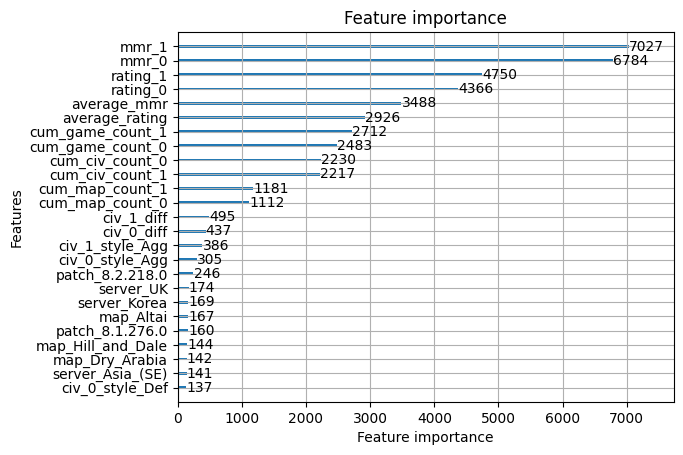

In [326]:
lightgbm.plot_importance(temp.lgbm_model, max_num_features= 25)

In [ ]:
sns.histplot(dataset["result_0"])
#we might need to scramble 

In [ ]:
#distribution of the game duration
sns.histplot(dataset[dataset["duration"].between(0, dataset["duration"].quantile(0.99))]["duration"])
plt.axvline(300, 0, color = "red")

<Axes: xlabel='average_rating', ylabel='duration'>

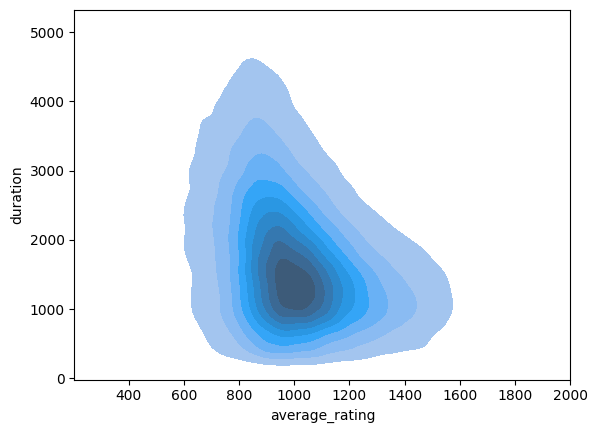

In [ ]:
""" sns.kdeplot(data=filter_rating, x= "average_rating", y = "duration", fill=True) """

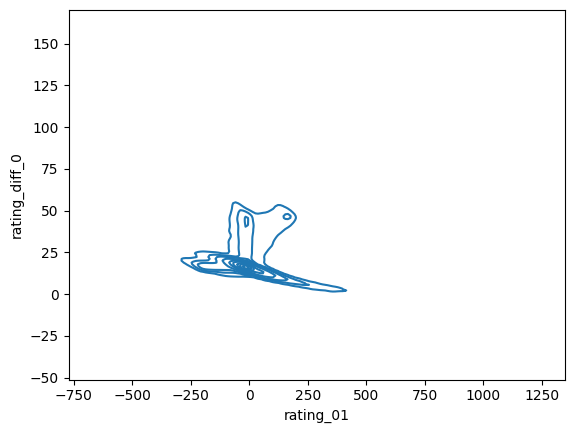

In [ ]:
rating = filter_rating.filter(regex = "rating|result")
rating = pd.get_dummies(rating, columns = ["result_0"])
rating["rating_01"] = rating["rating_0"] - rating["rating_1"]
rating_vars = rating.filter(regex = "rating_0|result_0|rating_diff_0").drop(columns = ["result_0_loss", "result_0_noresult", "result_0_unknown"])
win_0_rating_change = rating_vars[rating_vars["result_0_win"]]
rating_change0_plot = sns.kdeplot(x = "rating_01", y = "rating_diff_0", data=win_0_rating_change)